### Forecasting - Iraq

In [1]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import regularizers


pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

Using TensorFlow backend.


In [2]:
df = pd.read_csv('data/conflict-clusters.csv')

In [4]:
# Locating events within Iraq
data = df.loc[df['country'] == 'Iraq', :]

In [6]:
data.shape

(10360, 58)

In [7]:
# Dropping columns not used in modeling 
data.drop(columns=['year', 
                   'sub_event_type',
                   'actor1',
                   'assoc_actor_1',
                   'inter1',
                   'actor2',
                   'assoc_actor_2',
                   'inter2',
                   'interaction',
                   'region',
                   'admin2',
                   'admin3',
                   'location',
                   'timestamp',
                   'country',
                   'MA/CU'], inplace=True)

In [8]:
# calculating weekly count of events for dataframe
df = (pd.to_datetime(data['event_date']).dt.floor('d').value_counts().rename_axis('date').reset_index(name='count'))

In [10]:
data['event_date'] = pd.to_datetime(data['event_date'])

In [11]:
# Merging Iraq data and weekly even count
data = pd.merge(data, df, left_on='event_date', right_on='date', how='outer')

In [13]:
data.set_index('event_date', inplace=True)

In [14]:
data.drop(columns='date', inplace=True)

In [15]:
pd.get_dummies(data=data, 
               columns=['event_type',
                        'admin1'])

,latitude,longitude,geo_precision,fatalities,users,frac,month,missing_data,Exchange rate USD,Unemployment rate,Rule of law index (-2.5 weak; 2.5 strong),Government effectiveness index (-2.5 weak; 2.5 strong),Control of corruption (-2.5 weak; 2.5 strong),Regulatory quality index (-2.5 weak; 2.5 strong),Voice and accountability index (-2.5 weak; 2.5 strong),Political stability index (-2.5 weak; 2.5 strong),Corruption Perceptions Index 100 = no corruption,Political rights index 7 (weak) - 1 (strong),Civil liberties index 7 (weak) - 1 (strong),Short-term political risk (1=low 7=high),Medium/long-term political risk (1=low 7=high),Political violence risk (1=low 7=high),Mobile phone subscribers per 100 people,Property rights index (0-100),Freedom from corruption index (0-100),Business freedom index (0-100),Labor freedom index (0-100),Life expectancy in years,Fragile state index 0 (low) - 120 (high),Security threats index 0 (low) - 10 (high),State legitimacy index 0 (high) - 10 (low),Public services index 0 (high) - 10 (low),Human rights and rule of law index 0 (high) - 10 (low),Refugees and displaced persons index 0 (low) - 10 (high),Labor force million people,Labor force participation rate,Percent urban population,Population density people per square km,db_50_clusters,count,event_type_Battles,event_type_Explosions/Remote violence,event_type_Protests,event_type_Riots,event_type_Violence against civilians,admin1_Anbar,admin1_Babylon,admin1_Baghdad,admin1_Basrah,admin1_Dahuk,admin1_Diyala,admin1_Erbil,admin1_Kerbala,admin1_Kirkuk,admin1_Missan,admin1_Muthanna,admin1_Najaf,admin1_Ninewa,admin1_Qadissiya,admin1_Sala al-Din,admin1_Sulaymaniyah,admin1_Thi-Qar,admin1_Wassit
event_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,34.1915,42.0313,3,6,46,56,1,0.0,1181.5465,13.02,-1.64,-1.26,-1.37,-1.20,-1.05,-2.31,18,5,6,6,7,7,88.98,37,19,61,68,70.29,105.4,10.0,9.5,8.2,8.7,9.9,9.77,42.49,70.280,87.0,1,11,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-01-01,36.3350,43.1189,1,20,46,56,1,0.0,1181.5465,13.02,-1.64,-1.26,-1.37,-1.20,-1.05,-2.31,18,5,6,6,7,7,88.98,37,19,61,68,70.29,105.4,10.0,9.5,8.2,8.7,9.9,9.77,42.49,70.280,87.0,1,11,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2017-01-01,32.0259,44.3462,2,6,46,56,1,0.0,1181.5465,13.02,-1.64,-1.26,-1.37,-1.20,-1.05,-2.31,18,5,6,6,7,7,88.98,37,19,61,68,70.29,105.4,10.0,9.5,8.2,8.7,9.9,9.77,42.49,70.280,87.0,1,11,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2017-01-01,31.8044,44.4893,1,0,46,56,1,0.0,1181.5465,13.02,-1.64,-1.26,-1.37,-1.20,-1.05,-2.31,18,5,6,6,7,7,88.98,37,19,61,68,70.29,105.4,10.0,9.5,8.2,8.7,9.9,9.77,42.49,70.280,87.0,1,11,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2017-01-01,36.3072,43.1999,1,19,46,56,1,0.0,1181.5465,13.02,-1.64,-1.26,-1.37,-1.20,-1.05,-2.31,18,5,6,6,7,7,88.98,37,19,61,68,70.29,105.4,10.0,9.5,8.2,8.7,9.9,9.77,42.49,70.280,87.0,1,11,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31,30.4110,47.6522,1,0,36,55,12,0.0,1192.0100,12.82,-1.70,-1.29,-1.39,-1.21,-1.02,-2.44,20,5,6,6,7,6,92.01,37,20,54,53,70.37,99.1,8.7,8.9,8.7,8.1,9.1,10.38,42.60,70.375,88.0,9,12,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-12-31,30.5330,47.7975,2,0,36,55,12,0.0,1192.0100,12.82,-1.70,-1.29,-1.39,-1.21,-1.02,-2.44,20,5,6,6,7,6,92.01,37,20,54,53,70.37,99.1,8.7,8.9,8.7,8.1,9.1,10.38,42.60,70.375,88.0,9,12,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-12-31,32.5979,44.0165,1,0,36,55,12,0.0,1192.0100,12.82,-1.70,-1.29,-1.39,-1.21,-1.02,-2.44,20,5,6,6,7,6,92.01,37,20,54,53,70.37,99.1,8.7,8.9,8.7,8.1,9.1,10.38,42.60,70.375,88.0,1,12,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [16]:
data.drop(columns=['event_type', 'admin1'], inplace=True)

In [17]:
y = data['count']
X = data.drop(columns=['count'])


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [19]:
minmax = MinMaxScaler()

In [20]:
# Normalizing numeric data
X_train = minmax.fit_transform(X_train)
X_test = minmax.fit_transform(X_test)

In [21]:
X_train.shape

(7770, 39)

In [31]:
train = TimeseriesGenerator(X_train, y_train, length=3, batch_size=64)
test = TimeseriesGenerator(X_test, y_test, length=3, batch_size=64)

In [32]:
batch_x, batch_y = train[0]

In [33]:
batch_x.shape

(64, 3, 39)

In [40]:
# The LSTM design
model = Sequential()
# First LSTM layer with Dropout 
model.add(LSTM(64, activation='relu', kernel_regularizer=regularizers.l1(1e-5),return_sequences=True, input_shape=(3, 39)))
model.add(Dropout(0.7))
# Second LSTM layer
model.add(LSTM(units=64, kernel_regularizer=regularizers.l1(1e-5),activation='relu', return_sequences=True))
model.add(Dropout(0.7))
# Third LSTM layer
model.add(LSTM(units=64, kernel_regularizer=regularizers.l1(1e-5),activation='relu', return_sequences=True))
model.add(Dropout(0.7))
# The output layer

model.add(Flatten())
model.add(Dense(1))

# Compiling the RNN
model.compile(optimizer='Adam', loss='mean_absolute_percentage_error')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 3, 64)             26624     
_________________________________________________________________
dropout_13 (Dropout)         (None, 3, 64)             0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 3, 64)             33024     
_________________________________________________________________
dropout_14 (Dropout)         (None, 3, 64)             0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 3, 64)             33024     
_________________________________________________________________
dropout_15 (Dropout)         (None, 3, 64)             0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 192)              

In [41]:
# Fitting to the training set
hist = model.fit_generator(train, validation_data=(test), epochs=50)

Epoch 1/50
122/122 [==============================] - 2s 19ms/step - loss: 60.0879 - val_loss: 88.7931
Epoch 2/50
122/122 [==============================] - 1s 8ms/step - loss: 42.1172 - val_loss: 83.2539
Epoch 3/50
122/122 [==============================] - 1s 8ms/step - loss: 40.8777 - val_loss: 71.2446
Epoch 4/50
122/122 [==============================] - 1s 8ms/step - loss: 37.6962 - val_loss: 69.4928
Epoch 5/50
122/122 [==============================] - 1s 8ms/step - loss: 37.6353 - val_loss: 69.4116
Epoch 6/50
122/122 [==============================] - 1s 8ms/step - loss: 37.2209 - val_loss: 69.8103
Epoch 7/50
122/122 [==============================] - 1s 8ms/step - loss: 36.5403 - val_loss: 61.8351
Epoch 8/50
122/122 [==============================] - 1s 8ms/step - loss: 37.7471 - val_loss: 60.3822
Epoch 9/50
122/122 [==============================] - 1s 7ms/step - loss: 36.1059 - val_loss: 62.0459
Epoch 10/50
122/122 [==============================] - 1s 7ms/step - loss: 36.405

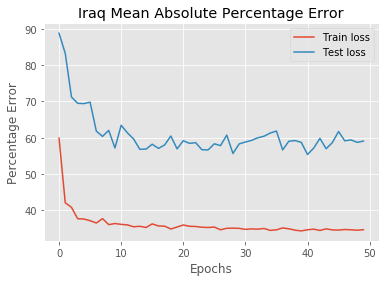

In [50]:

plt.style.use('ggplot')
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label='Test loss')
plt.title('Iraq Mean Absolute Percentage Error')
plt.xlabel('Epochs')
plt.ylabel('Percentage Error')
plt.legend()
plt.savefig('imgs/iraqloss.jpeg');

In [44]:
iraq_preds = model.predict(test)

In [51]:
def plot_predictions(test,predicted):
    plt.plot(test, label='True Values')
    plt.plot(predicted, label='Predicted Values')
    plt.title('Iraq Forecast')
    plt.xlabel('Time')
    plt.ylabel('Weekly Count of Events')
    plt.legend()
    plt.savefig('imgs/iraqforecast.jpeg');

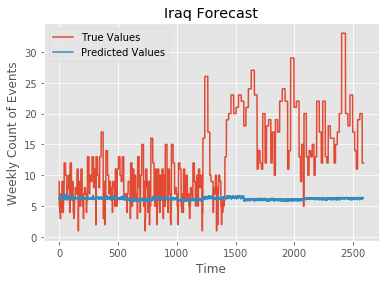

In [52]:
plot_predictions(y_test.values, iraq_preds)